In [1]:
import polars as pl
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
import xgboost as xgb
from sklearn.metrics import  f1_score, roc_auc_score, average_precision_score, classification_report, confusion_matrix, recall_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
df = pl.read_parquet('data/training_ready/data_2025-07-08.parquet')

In [ ]:
df.schema

In [3]:
def get_balanced_train_test(data: pl.DataFrame):
    if isinstance(data, pl.DataFrame):
        df_pandas = data.to_pandas()
    else:
        df_pandas = data.copy()

    majority = df_pandas[df_pandas['is_potentially_hazardous'] == 0]
    minority = df_pandas[df_pandas['is_potentially_hazardous'] == 1]

    minority_undersampled = resample(
        minority, 
        replace=True,
        n_samples=len(majority),
        random_state=42
    )

    df_balanced = pd.concat([majority, minority_undersampled])
    df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle

    print(f"Balanced dataset size: {len(df_balanced)}")
    print(f"Balanced class distribution:")
    print(df_balanced['is_potentially_hazardous'].value_counts())

    # Now use this balanced dataset
    X_balanced = df_balanced.drop(['is_potentially_hazardous'], axis=1)
    y_balanced = df_balanced['is_potentially_hazardous']

    y_balanced = y_balanced.astype(int)

    return X_balanced, y_balanced

In [4]:
X_balanced, y_balanced = get_balanced_train_test(data=df)

Balanced dataset size: 504936
Balanced class distribution:
is_potentially_hazardous
0    252468
1    252468
Name: count, dtype: int64


In [5]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X_balanced, y_balanced, test_size=0.4, stratify=y_balanced, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

In [6]:
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.ensemble import (
    RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier,
    GradientBoostingClassifier, VotingClassifier, BaggingClassifier
)
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from imblearn.ensemble import (
    BalancedRandomForestClassifier, EasyEnsembleClassifier, 
    RUSBoostClassifier, BalancedBaggingClassifier
)

models = {
    'XGBoost': xgb.XGBClassifier(
        scale_pos_weight=1.0,
        eval_metric='logloss',
        n_estimators=1000,
        early_stopping_rounds=50,
        learning_rate=0.1,
        max_depth=6,
        random_state=42,
        n_jobs=-1
    )    
}

[0]	validation_0-logloss:0.63554	validation_1-logloss:0.63550
[1]	validation_0-logloss:0.58818	validation_1-logloss:0.58810
[2]	validation_0-logloss:0.54884	validation_1-logloss:0.54872
[3]	validation_0-logloss:0.51575	validation_1-logloss:0.51560
[4]	validation_0-logloss:0.48757	validation_1-logloss:0.48739
[5]	validation_0-logloss:0.46372	validation_1-logloss:0.46350
[6]	validation_0-logloss:0.44314	validation_1-logloss:0.44291
[7]	validation_0-logloss:0.42508	validation_1-logloss:0.42488
[8]	validation_0-logloss:0.40959	validation_1-logloss:0.40935
[9]	validation_0-logloss:0.39605	validation_1-logloss:0.39577
[10]	validation_0-logloss:0.38424	validation_1-logloss:0.38392
[11]	validation_0-logloss:0.37383	validation_1-logloss:0.37352
[12]	validation_0-logloss:0.36480	validation_1-logloss:0.36450
[13]	validation_0-logloss:0.35683	validation_1-logloss:0.35653
[14]	validation_0-logloss:0.34980	validation_1-logloss:0.34950
[15]	validation_0-logloss:0.34366	validation_1-logloss:0.34338
[1

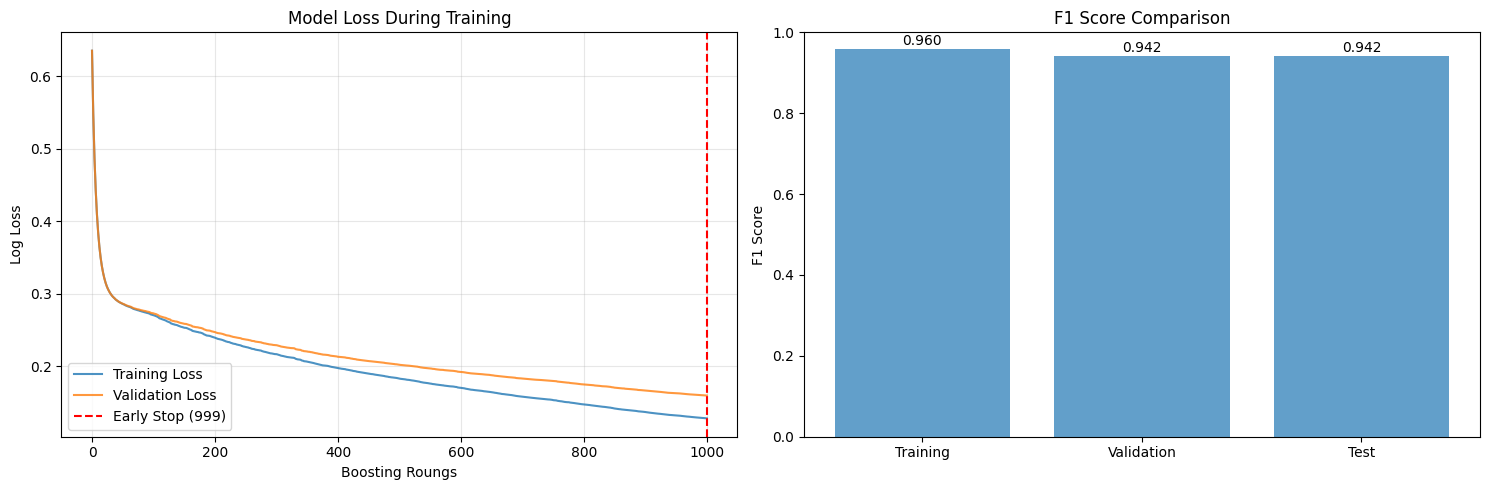

XGBoost


In [19]:
def evaluate_model(mode, model_name, X_train, X_test, X_val, y_train, y_test, y_val):
    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        verbose=True
    )

    results = model.evals_result()


    # Plot training vs validation
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    # Loss curves
    ax1.plot(results['validation_0']['logloss'], label='Training Loss', alpha=0.8)
    ax1.plot(results['validation_1']['logloss'], label='Validation Loss', alpha=0.8)
    ax1.set_title('Model Loss During Training')
    ax1.set_xlabel('Boosting Rounds')
    ax1.set_ylabel('Log Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Add early stoppping line
    if hasattr(model, 'best_iteration'):
        ax1.axvline(x=model.best_iteration, color='red', linestyle='--', label=f'Early Stop ({model.best_iteration})')
        ax1.legend()
    
    train_pred = model.predict(X_train)
    val_pred = model.predict(X_val)
    test_pred = model.predict(X_test)
    test_pred_proba = model.predict_proba(X_test)[:, 1]

    scores = {
        'Training': f1_score(y_train, train_pred),
        'Validation': f1_score(y_val, val_pred),
        'Test': f1_score(y_test, test_pred)
    }

    ax2.bar(scores.keys(), scores.values(), alpha=0.7)
    ax2.set_title("F1 Score Comparison")
    ax2.set_ylabel("F1 Score")
    ax2.set_ylim(0, 1)

    # Add value labels on bars
    for i, (k, v) in enumerate(scores.items()):
        ax2.text(i, v + 0.01, f'{v:.3f}', ha='center')

    plt.tight_layout()
    plt.show()

    
    metrics = {
        'model': model_name,
        'f1': f1_score(y_test, test_pred),
        'roc_auc': roc_auc_score(y_test, test_pred_proba),
        'precision': average_precision_score(y_test, test_pred),
        'recall': recall_score(y_test, test_pred),
        'accuracy': accuracy_score(y_test, test_pred)
    }
    print(model_name)
    return metrics, model

results = []
trained_models = {}

for name, model in models.items():
    try:
        metrics, trained_model = evaluate_model(model, name, X_train, X_test, X_val, y_train, y_test, y_val)
        results.append(metrics)
        trained_models[name] = trained_model
    except Exception as e:
        print(f"Error with {name}: {str(e)}")

In [30]:
trained_models

{'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=50,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, feature_weights=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.1, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=6, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=1000, n_jobs=-1,
               num_parallel_tree=None, ...)}

In [39]:

import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, make_scorer
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import time


In [58]:
def astroid_scorer(y_true, y_pred):
    f1 = f1_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    return 0.7 * f1 + 0.3 * recall

asteroid_score = make_scorer(astroid_scorer)

class XGBTuner:
    def __init__(self, X_train, y_train, X_val, y_val, X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.X_test = X_test
        self.y_test = y_test
        self.best_params = {}
        self.tuning_results = {}

    def evaluate_model(self, model, stage_name):
        """Evaluate model and store results"""
        start_time = time.time()
        
        # Fit model
        model.fit(
            self.X_train, self.y_train,
            eval_set=[(self.X_train, self.y_train), (self.X_val, self.y_val)],
            verbose=False
        )
        
        # Get predictions
        train_pred = model.predict(self.X_train)
        val_pred = model.predict(self.X_val)
        test_pred = model.predict(self.X_test)
        test_pred_proba = model.predict_proba(self.X_test)[:, 1]
        
        # Calculate metrics
        results = {
            'stage': stage_name,
            'train_f1': f1_score(self.y_train, train_pred),
            'val_f1': f1_score(self.y_val, val_pred),
            'test_f1': f1_score(self.y_test, test_pred),
            'test_precision': precision_score(self.y_test, test_pred),
            'test_recall': recall_score(self.y_test, test_pred),
            'test_roc_auc': roc_auc_score(self.y_test, test_pred_proba),
            'training_time': time.time() - start_time,
            'params': model.get_params()
        }
        
        # Check for overfitting
        results['overfitting_gap'] = results['train_f1'] - results['val_f1']
        
        return results
    
    def stage_1_core_params(self):
        param_grid = {
            'n_estimators': [300, 500, 800, 1200],
            'learning_rate': [0.03, 0.05, 0.1, 0.15]
        }

        base_model = XGBClassifier(
            max_depth=5,
            random_state=42,
            eval_metric='logloss'
        )

        grid = GridSearchCV(
            base_model,
            param_grid,
            cv=3,
            scoring=asteroid_score,
            n_jobs=-1,
            verbose=1
        )

        grid.fit(self.X_train, self.y_train)

        # Update best params
        self.best_params.update(grid.best_params_)

        best_model = grid.best_estimator_
        results = self.evaluate_model(best_model, "Stage 1: Core Params")
        self.tuning_results['stage_1'] = results

        print(f"✅ Stage 1 Complete!")
        print(f"Best params: {grid.best_params_}")
        print(f"Validation F1: {results['val_f1']:.4f}, Test F1: {results['test_f1']:.4f}")
        print(f"Overfitting gap: {results['overfitting_gap']:.4f}")
        print("-" * 60)

        return best_model

    def stage_2_tree_structure(self):
        param_grid = {
            'max_depth': [4, 5, 6, 7],
            'min_child_weight': [2, 3, 4, 5],
            'subsample': [0.8, 0.85, 0.9, 1.0]
        }

        base_model = XGBClassifier(
            n_estimators=self.best_params['n_estimators'],
            learning_rate=self.best_params['learning_rate'],
            random_state=42,
            eval_metric='logloss'
        )

        grid = RandomizedSearchCV(
            base_model,
            param_grid,
            n_iter=20,
            cv=3,
            scoring=asteroid_score,
            n_jobs=-1,
            verbose=1,
            random_state=42
        )

        grid.fit(self.X_train, self.y_train)

        self.best_params.update(grid.best_params_)

        best_model = grid.best_estimator_
        results = self.evaluate_model(best_model, 'Stage 2: Tree Structure')
        self.tuning_results['stage_2'] = results

        print(f"✅ Stage 2 Complete!")
        print(f"Best params: {grid.best_params_}")
        print(f"Validation F1: {results['val_f1']:.4f}, Test F1: {results['test_f1']:.4f}")
        print(f"Overfitting gap: {results['overfitting_gap']:.4f}")
        print("-" * 60)
        
        return best_model

    def stage_3_feature_sampling(self):
        param_grid = {
            'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
            'colsample_bylevel': [0.8, 0.9, 1.0]
        }

        base_model = XGBClassifier(
            n_estimators=self.best_params['n_estimators'],
            learning_rate=self.best_params['learning_rate'],
            max_depth=self.best_params['max_depth'],
            min_child_weight=self.best_params['min_child_weight'],
            subsample=self.best_params['subsample'],
            random_state=42,
            eval_metric='logloss'
        )

        grid = GridSearchCV(
            base_model,
            param_grid,
            cv=3,
            scoring=asteroid_score,
            n_jobs=-1,
            verbose=1
        )

        grid.fit(self.X_train, self.y_train)

        self.best_params.update(grid.best_params_)

        best_model = grid.best_estimator_
        results = self.evaluate_model(best_model, 'Stage 3: Feature Sampling')
        self.tuning_results['stage_3'] = results

        print(f"✅ Stage 3 Complete!")
        print(f"Best params: {grid.best_params_}")
        print(f"Validation F1: {results['val_f1']:.4f}, Test F1: {results['test_f1']:.4f}")
        print(f"Overfitting gap: {results['overfitting_gap']:.4f}")
        print("-" * 60)
        
        return best_model
    
    def stage_4_regularisation(self):
        param_grid = {
            'reg_alpha': [0, 0.1, 0.3, 0.5],
            'reg_lambda': [1, 2, 3, 5],
            'gamma': [0, 0.1, 0.2, 0.3]
        }

        base_model = XGBClassifier(
            n_estimators=self.best_params['n_estimators'],
            learning_rate=self.best_params['learning_rate'],
            max_depth=self.best_params['max_depth'],
            min_child_weight=self.best_params['min_child_weight'],
            subsample=self.best_params['subsample'],
            colsample_bytree=self.best_params['colsample_bytree'],
            colsample_bylevel=self.best_params['colsample_bylevel'],
            random_state=42,
            eval_metric='logloss'
        )

        grid = RandomizedSearchCV(
            base_model,
            param_grid,
            n_iter=15,  # Try 15 combinations
            cv=3,
            scoring=asteroid_score,
            n_jobs=-1,
            verbose=1,
            random_state=42
        )
        
        grid.fit(self.X_train, self.y_train)
        
        # Update best params
        self.best_params.update(grid.best_params_)
        
        # Evaluate best model
        best_model = grid.best_estimator_
        results = self.evaluate_model(best_model, "Stage 4: Regularization")
        self.tuning_results['stage_4'] = results
        
        print(f"✅ Stage 4 Complete!")
        print(f"Best params: {grid.best_params_}")
        print(f"Validation F1: {results['val_f1']:.4f}, Test F1: {results['test_f1']:.4f}")
        print(f"Overfitting gap: {results['overfitting_gap']:.4f}")
        print("-" * 60)
        
        return best_model

    def run_full_tuning(self):
        baseline = XGBClassifier(random_state=42)
        baseline_results = self.evaluate_model(baseline, "Baseline")
        self.tuning_results['baseline'] = baseline_results

        print(f"📊 Baseline Performance:")
        print(f"Test F1: {baseline_results['test_f1']:.4f}")
        print(f"Test Recall: {baseline_results['test_recall']:.4f}")
        print("-" * 60)

        # Run tuning stages
        self.stage_1_core_params()
        self.stage_2_tree_structure()
        self.stage_3_feature_sampling()
        self.stage_4_regularisation()

        self.evaluate_final_model()

        return self.best_params

    def evaluate_final_model(self):

        final_model = XGBClassifier(**self.best_params, random_state=42)
        final_results = self.evaluate_model(final_model, 'Final Optimised Model')
        self.tuning_results['final'] = final_results 

        baseline_f1 = self.tuning_results['baseline']['test_f1']
        final_f1 = final_results['test_f1']
        improvement = final_f1 - baseline_f1

        print(f"🎉 FINAL RESULTS:")
        print(f"Baseline F1:     {baseline_f1:.4f}")
        print(f"Optimized F1:    {final_f1:.4f}")
        print(f"Improvement:     {improvement:+.4f}")
        print(f"Final Recall:    {final_results['test_recall']:.4f}")
        print(f"Final Precision: {final_results['test_precision']:.4f}")
        print(f"Final ROC AUC:   {final_results['test_roc_auc']:.4f}")
        print(f"Overfitting gap: {final_results['overfitting_gap']:.4f}")

        for param, value in self.best_params.items():
            print(f"  {param}: {value}")

    def plot_tuning_progress(self):
        """Plot tuning progress across stages"""
        stages = ['baseline', 'stage_1', 'stage_2', 'stage_3', 'stage_4', 'final']
        stage_names = ['Baseline', 'Core Params', 'Tree Structure', 'Feature Sampling', 'Regularization', 'Final']
        
        f1_scores = [self.tuning_results[stage]['test_f1'] for stage in stages]
        recall_scores = [self.tuning_results[stage]['test_recall'] for stage in stages]
        overfitting_gaps = [self.tuning_results[stage]['overfitting_gap'] for stage in stages]
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Performance progression
        ax1.plot(stage_names, f1_scores, 'o-', label='F1 Score', linewidth=2, markersize=8)
        ax1.plot(stage_names, recall_scores, 's-', label='Recall', linewidth=2, markersize=8)
        ax1.set_title('Model Performance Progression', fontsize=14)
        ax1.set_ylabel('Score', fontsize=12)
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        ax1.tick_params(axis='x', rotation=45)
        
        # Overfitting progression
        ax2.bar(stage_names, overfitting_gaps, alpha=0.7, color='orange')
        ax2.set_title('Overfitting Gap Progression', fontsize=14)
        ax2.set_ylabel('Train F1 - Validation F1', fontsize=12)
        ax2.axhline(y=0.05, color='red', linestyle='--', alpha=0.7, label='Overfitting Threshold')
        ax2.legend()
        ax2.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()



In [59]:
trained_models

{'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=50,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, feature_weights=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.1, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=6, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=1000, n_jobs=-1,
               num_parallel_tree=None, ...)}

In [60]:
tuner = XGBTuner(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, X_test=X_test, y_test=y_test)

In [61]:
best_params = tuner.run_full_tuning()

📊 Baseline Performance:
Test F1: 0.9151
Test Recall: 0.9920
------------------------------------------------------------
Fitting 3 folds for each of 16 candidates, totalling 48 fits
✅ Stage 1 Complete!
Best params: {'learning_rate': 0.15, 'n_estimators': 1200}
Validation F1: 0.9422, Test F1: 0.9426
Overfitting gap: 0.0175
------------------------------------------------------------
Fitting 3 folds for each of 20 candidates, totalling 60 fits
✅ Stage 2 Complete!
Best params: {'subsample': 0.9, 'min_child_weight': 2, 'max_depth': 7}
Validation F1: 0.9687, Test F1: 0.9687
Overfitting gap: 0.0294
------------------------------------------------------------
Fitting 3 folds for each of 12 candidates, totalling 36 fits
✅ Stage 3 Complete!
Best params: {'colsample_bylevel': 1.0, 'colsample_bytree': 0.8}
Validation F1: 0.9689, Test F1: 0.9694
Overfitting gap: 0.0291
------------------------------------------------------------
Fitting 3 folds for each of 15 candidates, totalling 45 fits
✅ Stage 

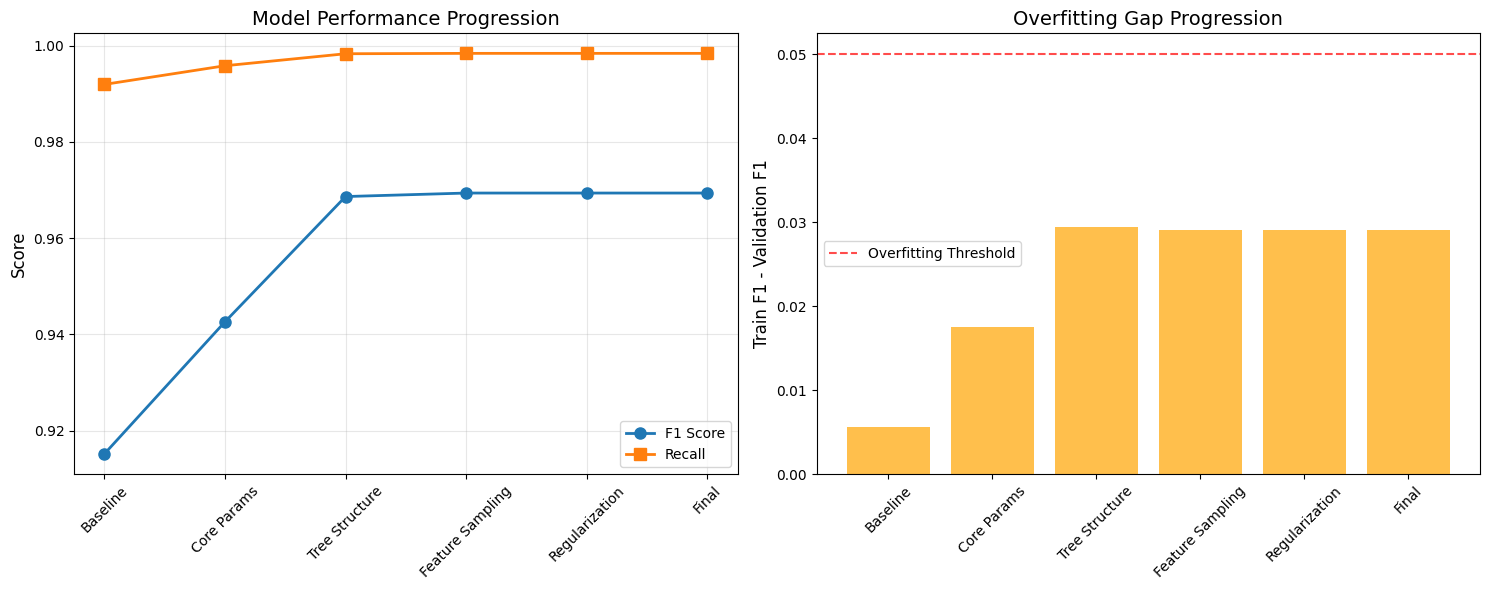

In [62]:
tuner.plot_tuning_progress()

In [63]:
final_model = XGBClassifier(**best_params, random_state=42)
final_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=1.0, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.15, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=2, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1200,
              n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
from 